Title: Facebook

Introduction:
We will be using the different metrics for Facebook posts, such as Lifetime Engaged Users,
to make a prediction on the if the post was paid or not. We will choose two metrics to use to determine what type of post it is through splitting the data and training/testing. The dataset we have is from 2014 Facebook posts of a renowed cosmeitc brand and it shows the type of post(paid vs unpaid) and information on the people who liked or engaged with it.


Preliminary exploratory data analysis:
The dataset is downloadable in csv format, which we could upload to jupyter. We don’t have to tidy it as it is already in tidy format.


In [7]:
library(tidyverse)
library(repr)
library(tidymodels)

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3      ✔ yardstick 0.0.7 

Warning message:
“package ‘broom’ was built under R version 4.0.2”
Warning message:
“package ‘dials’ was built under R version 4.0.2”
Warning message:
“package ‘infer’ was built under R version 4.0.3”
Warning message:
“package ‘modeldata’ was built under R version 4.0.1”
Warning message:
“package ‘parsnip’ was built under R version 4.0.2”
Warning message:
“package ‘recipes’ was built under R version 4.0.1”
Warning message:
“package ‘tune’ was built under R version 4.0.2”
Warning message:
“package ‘workflows’ was built under R version 4.0.2”
Warning message:
“package ‘yardstick’ was built under R version 4.0.2”
── Conflicts ────

`summarise()` ungrouping output (override with `.groups` argument)



Paid,n,LifetimePostTotalReachMean,LifetimePostLikeMean
<fct>,<int>,<dbl>,<dbl>
0,280,11458.23,579.0107
1,95,20663.29,679.3368


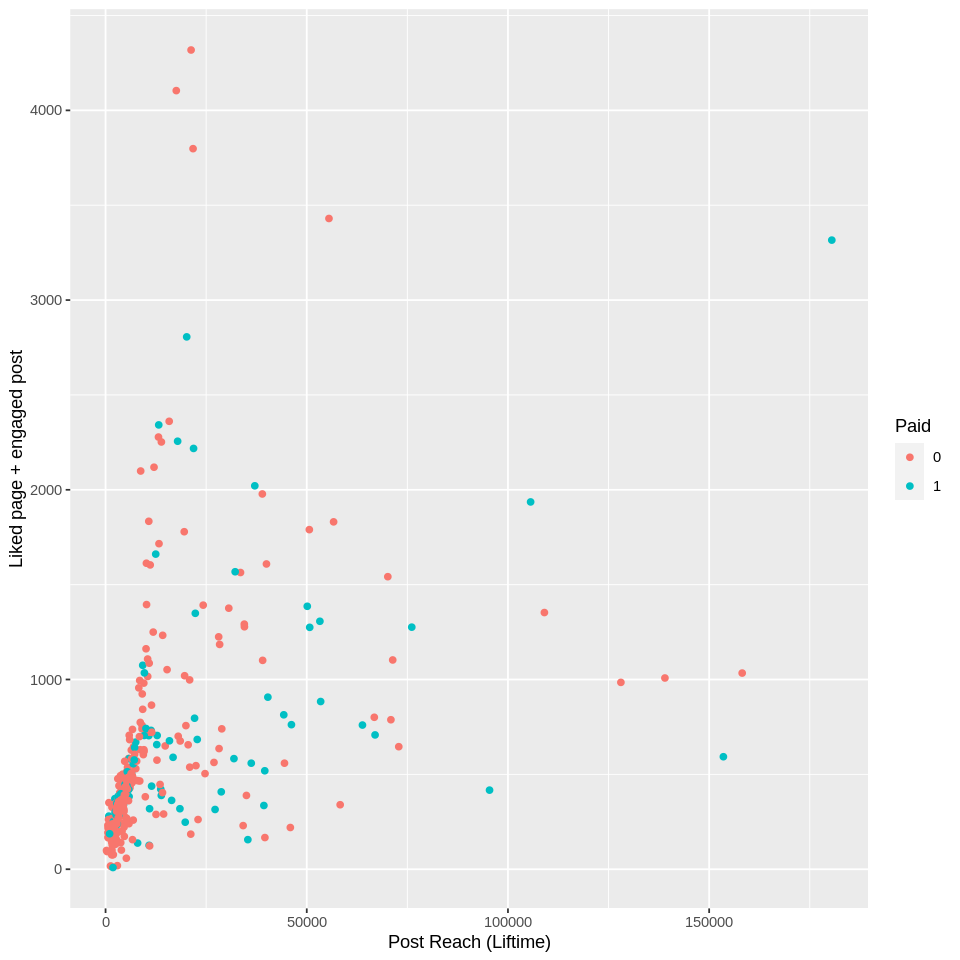

In [45]:
set.seed(3060)
options(repr.plot.width = 8, repr.plot.height = 8)
facebook <- mutate(read.delim('data/dataset_Facebook.csv', sep=';'), Paid=as_factor(Paid))

facebook_split <- initial_split(facebook, prop = 0.75, strata = Type) 
facebook_train <- training(facebook_split)   
facebook_test <- testing(facebook_split)

facebook_group <- facebook_train %>% group_by(Paid)%>% 
summarize(n=n(),LifetimePostTotalReachMean = mean(Lifetime.Post.Total.Reach, na.rm =TRUE), LifetimePostLikeMean = mean(Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post, na.RM=TRUE))
facebook_group

facebook_plot <- facebook_train %>% ggplot(aes(x=Lifetime.Post.Total.Reach, 
            y=Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post)) + 
            geom_point(aes(color=Paid)) + labs(x='Post Reach (Liftime)', y='Liked page + engaged post', color='Paid')

facebook_plot


Methods:
We will use the recipe/model to conduct predictions on the training set. The columns we chose are the total reach and total people who liked the page and engaged the post for paid/unpaid posts. We can compare to see a higher a total reach and more engagements on the post means that the post is paid.
A higher total reach means more audience so we think that a post by a page with higher audiences is more likely to be paid because it is seen by more people, so leading to better advertisement/marketing strategy.
Similarly, we want to compare if the post is engaged and if the page is liked as this means that the consumers are more interested and invested in the contents page, meaning that the advertisement would work better.

As seen by the graph above, it is very hard for us to visualize the dots in the bottom left hand side, so we will probably be relying on prediction tables through training/testing datasets to see accuracy of predictions.

Expected outcomes and significance:
1. We expect to find a higher total post reach and higher liked page/engaged post for paid posts and opposite for unpaid.
2. If a business chooses to paid for a post, it would most likely have high reach. However, whether the user engages with the ad due to high engagement can be revealed to the business using our predictions. Just because people see the ad doesn't mean they click on it, which is a reason why we chose the two columns above to analyze.
3. Does a higher reach necessarily mean more people would be interested in the product regardless if quality of the product? What is the cutoff of reach numbers to classify a post as paid (ex. 30,000)? Should a company pay for a post only if it is guranteed a certain amount of reach? Is paid post automatically more liked/engaged than an unpaid post or are there other variables we should account for.
